## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 2

- **100 points [7% of your final grade]**
- **Due Sunday, March 6 by 11:59pm** 
- (*no submissions accepted after March 9 by 11:59pm*)

**Goals of this homework:** There are four objectives of this homework: 

* Become familiar with Apache Spark;
* Get hands-on experience using Spark built-in functions like PageRank;
* Work out Hubs and Authorities by hand;
* Try some LSH problems.

*Submission instructions:* You should post your notebook to canvas (look for the homework 2 assignment there). Name your submission **your-uin_hw2.ipynb**, so for example, my submission would be something like **555001234_hw2.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. When you are done, download your notebook from colab and submit it to canvas.

*Collaboration declaration:* If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

*Write your collaboration/references here*

## Preliminaries: Introduction to the Dataset
We will use a dataset of tweets concerning members of the US congress. The data spans almost a year (from October 3rd, 2018 to September 25th, 2019) covering 576 of the members. Any tweet or retweet posted by the 576 members or directed to them by other Twitter users were collected.

Originally there were more than 200 million tweets collected but we have sampled 400,000 tweets for this homework.

Below is a summary of all datasets used for this homework:

| Dataset                        | Description |
| :---                                                       | :---
| Congress members               | 576 twitter ids and screen names |
| Sample tweets                  |400k sample tweets|
| ~~User hashtags~~                  | ~~all pairs of <user, hashtag>~~|
| User mentions                  | all pairs of <src_user_id, src_dest_id, frequency> |



Following are the steps that you need to execute to install spark. Remember you need to execute them everytime after your runtime is disconnected

In [1]:
!pip install pyspark
!pip install graphframes
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 46.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=308f13ba4d6168153baba268d34d6630935d77599a20e20c05076bbb69f401c1
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 154 kB 4.2 MB/s 
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 

The cell below will download the dataset from S3 to us-congress-tweets directory

In [2]:
!mkdir us-congress-tweets
!wget https://us-congress.s3.amazonaws.com/congress_members.csv -O us-congress-tweets/congress_members.csv
!wget https://us-congress.s3.amazonaws.com/tweets-sample-400k.json -O us-congress-tweets/tweets-sample-400k.json
!wget https://us-congress.s3.amazonaws.com/user_hashtags-1m.csv -O us-congress-tweets/user_hashtags-1m.csv
!wget https://us-congress.s3.amazonaws.com/user_mentions.csv -O us-congress-tweets/user_mentions.csv

--2022-03-07 00:34:40--  https://us-congress.s3.amazonaws.com/congress_members.csv
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.36.132
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.36.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13835 (14K) [text/csv]
Saving to: ‘us-congress-tweets/congress_members.csv’

us-congress-tweets/ 100%[===================>]  13.51K  --.-KB/s    in 0s      

2022-03-07 00:34:41 (37.7 MB/s) - ‘us-congress-tweets/congress_members.csv’ saved [13835/13835]

--2022-03-07 00:34:41--  https://us-congress.s3.amazonaws.com/tweets-sample-400k.json
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.36.132
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.36.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202495914 (193M) [application/json]
Saving to: ‘us-congress-tweets/tweets-samp

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

In [4]:
# create a Spark session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4g').set('spark.driver.memory', '6g')

# create a Spark context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


In [5]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!./ngrok authtoken 25WdIriXJ0XxCJxPpdpVzNRaP80_7nMVhzVy7gcRsRcUkNZ17
!cat ~/.ngrok2/ngrok.yml
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2022-03-07 00:35:12--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  6.06MB/s    in 2.2s    

2022-03-07 00:35:15 (6.06 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
authtoken: 25WdIriXJ0XxCJxPpdpVzNRaP80_7nMVhzVy7gcRsRcUkNZ17
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


In [6]:
# First let's read Twitter ids and screen names of the 576 US congress members

congress_members = spark.read.csv("us-congress-tweets/congress_members.csv", header=True)
congress_members.show()
print("Number of congress members tracked:", congress_members.count())

+------------------+---------------+
|            userid|    screen_name|
+------------------+---------------+
|         776664410|  RepCartwright|
|         240363117|   RepTomMarino|
|837722935095930883| RepScottTaylor|
|        1069124515|     RepLaMalfa|
|818460870573441028|  RepTomGarrett|
|         163570705|     repcleaver|
|          19739126|      GOPLeader|
|          33563161| RepJoseSerrano|
|        2861616083|USRepGaryPalmer|
|        1074518754| SenatorBaldwin|
|         305620929|  Call_Me_Dutch|
|         381152398| RepTerriSewell|
|         834069080| RepDavidRouzer|
|         249787913|  SenatorCarper|
|         188019606|        Clyburn|
|         217543151|SenatorTimScott|
|          39249305| USRepMikeDoyle|
|          33537967|   amyklobuchar|
|         249410485|  SanfordBishop|
|          23124635|    TomColeOK04|
+------------------+---------------+
only showing top 20 rows

Number of congress members tracked: 576


We can use `spark.read.json(...)` without schema to load the tweets into a dataframe but this will be slow for two reasons:
* First, it will make one pass over the data to build a schema of the content, then a second pass to read the content and parse it to the dataframe. 
* It will read all the content of the Tweet JSON objects but we only need few fields for a given task.

Thus we define our own schema something like the following:

In [7]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
twitter_date_format="EEE MMM dd HH:mm:ss ZZZZZ yyyy"

user_schema = StructType([
    StructField('created_at', TimestampType(), True),
    StructField('followers_count', LongType(), True),
    StructField('id', LongType(), True),
    StructField('name', StringType(), True),
    StructField('screen_name', StringType(), True)
])

hashtag_schema = ArrayType(StructType([StructField('text', StringType(), True)]))
user_mentions_schema = ArrayType(StructType([StructField('id', LongType(), True),
                                             StructField('screen_name', StringType(), True)]))
entities_schema = StructType([
    StructField('hashtags', hashtag_schema, True),
    StructField('user_mentions', user_mentions_schema, True)
    ])

retweeted_status_schema =StructType([        
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema)
    ])

tweet_schema =StructType([
        StructField("text", StringType(), True),
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema),
        StructField("entities", entities_schema),
        StructField("retweeted_status", retweeted_status_schema)
    ])

Now we are ready to read the tweets with `spark.read.json` passing our own schema as follows:

In [8]:
tweets = spark.read.option("timestampFormat", twitter_date_format)\
                   .json('us-congress-tweets/tweets-sample-400k.json', tweet_schema)\
                   .withColumn('user_id',F.col('user.id'))
tweets.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: long (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: timestamp (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- in_reply_to_user_id: long (nul

## (30 points) Part 1: Let's Fire up Spark for Real

Okay, now that we've finally got our data loaded, we are ready to get our hands dirty with Spark. As you know, Spark comes with lots of built-in functions and nice capabilities. Indeed, you will find that to answer the problems below, there are **many** possible approaches. Please refer to the Stanford Spark tutorial we posted alongside this homework. Also feel free to Google around for some Spark resources, but we list a few here to get you started:

* https://spark.apache.org/docs/latest/sql-ref-functions-builtin.html#aggregate-functions
* https://spark.apache.org/docs/latest/sql-getting-started.html#running-sql-queries-programmatically


### Exploratory Data Analysis

a) How many unique users are there? 

In [9]:
tweets.select('user_id').distinct().count()

198098

In [10]:
tweets.show()
tweets.printSchema()

+--------------------+-------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|                text|                 id|in_reply_to_user_id|in_reply_to_status_id|         created_at|                user|            entities|    retweeted_status|            user_id|
+--------------------+-------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|RT @maddow: "I he...|1047999818038050816|               null|                 null|2018-10-05 00:00:02|{2017-03-22 03:11...|{[], [{16129920, ...|{1047941326975766...| 844386122822119424|
|@ChuckGrassley @S...|1047999818579292160|           10615232|                 null|2018-10-05 00:00:02|{2016-01-29 01:49...|{[], [{10615232, ...|                null|         4828166688|
|RT @cm_merlin: @f...|1048000082237247488|               nul

b) How many times is the user **GOPLeader** mentioned?


In [11]:
# code here
a = tweets.select(tweets.id, F.explode(tweets.entities.user_mentions.screen_name).alias("userMention"))
a.filter(a.userMention == "GOPLeader").distinct().count()

4728

c) Now find the top-5 most mentioned members of Congress.

In [12]:
# code here
import pyspark.sql.functions as F
a = tweets.select(tweets.id, F.explode(tweets.entities.user_mentions.id)).withColumnRenamed('id', "mentionedTweet_id").distinct().groupBy('col').count()
congress_members.join(a, a.col == congress_members.userid, "inner").sort(F.desc("count")).show(5)

+----------+---------------+----------+-----+
|    userid|    screen_name|       col|count|
+----------+---------------+----------+-----+
|  15764644|    NancyPelosi|  15764644|16006|
|1249982359|   senatemajldr|1249982359|14903|
| 432895323|LindseyGrahamSC| 432895323|14251|
|  17494010|     SenSchumer|  17494010|13636|
|  29501253|  RepAdamSchiff|  29501253|13183|
+----------+---------------+----------+-----+
only showing top 5 rows



d) For each month in the dataset, report the top-5 most mentioned users (across all users in the dataset, not just the members of Congress). 

In [13]:
# code here
from pyspark.sql.functions import to_date, col, month, row_number
from pyspark.sql.window import Window
temp = tweets.select(F.explode(tweets.entities.user_mentions)).select(F.col("col.*")).distinct()
months = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
for i in months.keys():
  a = tweets.filter(month(col("created_at")) == i)
  b = a.select(a.id, F.explode(a.entities.user_mentions.id).alias('ID_user_mention'), month(a.created_at).alias('Month')).distinct()
  b = b.groupBy('ID_user_mention').count()
  print("Month of {}".format(months[i]))
  b.join(temp, b.ID_user_mention == temp.id, "inner").sort(col('count').desc()).drop('id', 'ID_user_mention').show(5)
  print("")

Month of January
+-----+---------------+
|count|    screen_name|
+-----+---------------+
| 4113|realDonaldTrump|
| 3741|  SpeakerPelosi|
| 3741|    NancyPelosi|
| 2781|     SenSchumer|
| 2557|   senatemajldr|
+-----+---------------+
only showing top 5 rows


Month of February
+-----+---------------+
|count|    screen_name|
+-----+---------------+
| 1872|     marcorubio|
| 1795|realDonaldTrump|
| 1167|  RepAdamSchiff|
| 1135|    NancyPelosi|
| 1135|  SpeakerPelosi|
+-----+---------------+
only showing top 5 rows


Month of March
+-----+---------------+
|count|    screen_name|
+-----+---------------+
| 2269|  RepAdamSchiff|
| 1893|realDonaldTrump|
| 1551|LindseyGrahamSC|
| 1474|     marcorubio|
| 1114|    NancyPelosi|
+-----+---------------+
only showing top 5 rows


Month of April
+-----+---------------+
|count|    screen_name|
+-----+---------------+
| 1832|  RepAdamSchiff|
| 1397|realDonaldTrump|
| 1196|    NancyPelosi|
| 1196|  SpeakerPelosi|
|  963|     SenSchumer|
+-----+----------

e) Do you notice anything interesting in your monthly analysis?

*your answer here*

From the monthly analysis, we can see that Donald Trump has always been in the top 5 of each month. It might be due to the upcoming elections. We also see that Speaker Pelosi was amongst the top 5 tweeters showing that she was an active member before the campaign too(she got elected as Speaker  of US House of Representatives in the year 2019). During 2018, there was a controversial bill for immigrants that Trump administration wanted to pass. This along with other revelations from attorney of Trump might be one of the reasons he has been mentioend so many times.

Nancy Pelosi, in 2018, had been blamed by the republicans to encoruage uprisings against the Trump administration. She also gave an record breaking 8 hour speech that year on the plan for recipients of the Obama-era Deferred Action for Childhood Arrivals program (DACA), due which she was quite in the headlines in the month of Febrary.

Eric Swalwell might have been mentioned a too many times due too his remark on confiscation of firearms and "nuking" anyone who opposes. This happened during the month of November, which is reflected from the analysis. Lisa Murkowski broke her ties from her party in the month of October and thu became the headlines in many news reports and twiter's mentions.

## (25 points) Part 2: PageRank
Now let's find out who are the most important users in the dataset by running PageRank over the mentions network. For this problem, we'll define a user-mentions network using relations in `us-congress-tweets/user_mentions.csv`. That is, each user is a node in the graph. If user A mentions user B, then there should be an edge from A to B.

Hint:
* Take a look at GraphFrames: https://graphframes.github.io/graphframes/docs/_site/user-guide.html


In [14]:
# your network construction code here
from graphframes import GraphFrame
congress_members_graph = spark.read.csv("us-congress-tweets/user_mentions.csv", header=True)
congress_members_graph.show(5)
final = congress_members_graph.select('src').union(congress_members_graph.select('dst')).distinct().withColumnRenamed('src','id')
final.show(5)
g = GraphFrame(final, congress_members_graph)

+------------------+----------+-----+
|               src|       dst|count|
+------------------+----------+-----+
|917194889275699201|1249982359|    1|
|917570582555779072| 251918778|    1|
|         633674091| 432895323|   48|
|913222391416934402| 432895323|  261|
|         217574712|  47203904|    1|
+------------------+----------+-----+
only showing top 5 rows

+-------------------+
|                 id|
+-------------------+
|          508996900|
|           53589935|
|           30191308|
|         1325721486|
|1025446910218227712|
+-------------------+
only showing top 5 rows



How many vertices are there in your network? And how many edges?

In [15]:
# your code
print("vertex count: "+ str(g.vertices.count()))
print("edge count: "+ str(g.edges.count()))

vertex count: 1133350
edge count: 2064872


Now you can run PageRank on the constructed network. Feel free to use the implementation provided as part of GraphFrames. Use a reset (or teleportation probability) of 0.15. 

In [33]:
# your PageRank code here (should be pretty short since you're just calling a function)
PR = g.pageRank(resetProbability=0.15, maxIter=20)

OK, let's see what we found. List the top-10 users based on the PageRank values calculated above.

In [41]:
# Top 10 accounts 
temp = congress_members.select(col('userid'), col('screen_name')).distinct()
pf = PR.vertices.select('id', 'pagerank')
pf.join( temp, pf.id == temp.userid, "left").orderBy(col('pagerank'),ascending=False).drop('userid').show(10)

+------------------+------------------+-------------+
|                id|          pagerank|  screen_name|
+------------------+------------------+-------------+
|          25073877|6811.7142315003375|         null|
|         240393970| 6209.614895740228|RepJeffDuncan|
|          15764644| 5192.227748818675|  NancyPelosi|
|        1249982359| 5155.754790420783| senatemajldr|
|822215679726100480|5096.8522186110085|         null|
|          29442313|4690.8686339571905|   SenSanders|
|          15745368| 4422.105425194594|   marcorubio|
|         242555999| 4333.292191898515|SenWhitehouse|
|          17494010| 4293.069505645255|   SenSchumer|
|         242426145| 4275.492617256165|  RepMcGovern|
+------------------+------------------+-------------+
only showing top 10 rows



What do you observe? are the top 10 users congress members? are there outsiders?

Hint: You can use https://twitter.com/intent/user?user_id=? to find out more info about the users

*your analysis here*

From the page rank analysis of the congress members, we can see that Null has the highest page rank. This account actually belonged to Donald Trump. But after his impeachment in 2020, his account has been removed from Twitter. Furthermore, in 2018, he wasnt a US Congressmen, thus no name is present in the databse. Following this is representatice Jeff Duncan and Nancy Pelosi. It is interesting to see the id "822215679726100480" too belongs to Donal Trump. The length of ID might show that this was a newly created account after the previous one was removed. We can see another interesting phenomena that, even though there are people millions of people following Bernie Sanders, he isnt at the top of the page rank list. Rather Jeff Duncan with a lower number of Followers and higer number of followings spars better in the page rank. This is due the fact that Bernie Sanders follows less number of people and currently we are just using a Vanilla page ranking algorithm

## (5 points) Bonus Question (Optional)
Until now you have explored different aspects of Spark to investigate tweets by the US Congress. For this (optional) bonus problem, please conduct your own investigation of the data. You can use any combinations of the data files to carry out your investigation. You may use any libraries in Spark that you like, but you must use Spark. Tell us what question motivates you, what you did, what you discovered, and why it is interesting. This is completely open-ended, but we are looking for compelling questions and insights. Good luck!



Feel free to add any number of code/text cells here for your answer!


In [51]:
tweets.select(F.explode(tweets.entities.hashtags)).select("col.*").groupBy('text').count().orderBy('count', ascending=False).show()

+-------------+-----+
|         text|count|
+-------------+-----+
|    Venezuela| 1224|
|  MoscowMitch| 1123|
|TrumpShutdown|  705|
|         MAGA|  535|
|MuellerReport|  396|
|  NancyPelosi|  349|
| MaduroRegime|  347|
|        Trump|  338|
| BuildTheWall|  333|
| GreenNewDeal|  297|
|    Kavanaugh|  292|
|     BREAKING|  277|
| ForThePeople|  224|
|       Maduro|  224|
|    Democrats|  194|
| DoWhatWeSaid|  179|
|      Mueller|  174|
|         SOTU|  173|
|          GOP|  171|
|          HR1|  168|
+-------------+-----+
only showing top 20 rows



* Venezuela has been the top mentions aside from US politicians due to crisis that erupted in 2018. Nicolas Maduro was the president then and he too is a top mention. During 2018, Maduro had won the re-elections of Venezulean government, but international observers said that it was fradulent. Due to his policies, there was hyperinflation and thus the currency fell and people came under the econimic crisis. Thus the hashtag "MaduroRegime". 

* Another few interesting hashtags related to same political incident are 'TrumpShutDown"and "BuildTheWall". In 2018, Congress has passed a huge sanction for the wall meant for the construction on the border of US-Mexico. This move, by the Trump administration, was to keep the illegal immigrants from Mexico from crossing the border. However, it wasnt well received by the people.
* Another interesting thing to note is the hashtag "MoscowMitch". Republican Leader Addison McConnell became infamous due to Democrats' allegations of him coluding with Putin to hinder USA's democratic elections because he blocked security measures for elections.

## (20 points) Hubs and Authorities by Hand

Consider the following graph (in adjacency list format):

* A: B, D (that is, A links to B and to D)
* B: D, E
* C: D, E
* D: F, G
* E: C, D, G, H
* F: 
* G: 
* H: C, G

Find the hub and authority score for each node. Please normalize your final scores so they sum to 1.

*show your steps here*
**Iteration 0**

> H(A) = 1 &emsp;&emsp; A(A) = 1

> H(B) = 1 &emsp;&emsp; A(B) = 1

> H(C) = 1 &emsp;&emsp; A(C) = 1

> H(D) = 1 &emsp;&emsp; A(D) = 1

> H(E) = 1 &emsp;&emsp; A(E) = 1

> H(F) = 1 &emsp;&emsp; A(F) = 1

> H(G) = 1 &emsp;&emsp; A(G) = 1

> H(H) = 1 &emsp;&emsp; A(H) = 1


---

**Iteration 1**

> H(A) = 2 &emsp;&emsp; A(A) = 0

> H(B) = 2 &emsp;&emsp; A(B) = 1

> H(C) = 2 &emsp;&emsp; A(C) = 2

> H(D) = 2 &emsp;&emsp; A(D) = 4

> H(E) = 4 &emsp;&emsp; A(E) = 2

> H(F) = 0 &emsp;&emsp; A(F) = 1

> H(G) = 0 &emsp;&emsp; A(G) = 3

> H(H) = 2 &emsp;&emsp; A(H) = 1
---
**Iteration 2**

> H(A) = 5 &emsp;&emsp; A(A) = 0

> H(B) = 6 &emsp;&emsp; A(B) = 2

> H(C) = 6 &emsp;&emsp; A(C) = 6

> H(D) = 4 &emsp;&emsp; A(D) = 10

> H(E) = 10 &emsp;&emsp; A(E) = 4

> H(F) = 0 &emsp;&emsp; A(F) = 2

> H(G) = 0 &emsp;&emsp; A(G) = 8

> H(H) = 5 &emsp;&emsp; A(H) = 4
---
**Iteration 3**

> H(A) = 12 &emsp;&emsp; A(A) = 0

> H(B) = 14 &emsp;&emsp; A(B) = 5

> H(C) = 14 &emsp;&emsp; A(C) = 15

> H(D) = 10 &emsp;&emsp; A(D) = 27

> H(E) = 28 &emsp;&emsp; A(E) = 12

> H(F) = 0 &emsp;&emsp; A(F) = 4

> H(G) = 0 &emsp;&emsp; A(G) = 19

> H(H) = 14 &emsp;&emsp; A(H) = 10
---
**Iteration 4**

> H(A) = 32 &emsp;&emsp; A(A) = 0

> H(B) = 39 &emsp;&emsp; A(B) = 12

> H(C) = 39 &emsp;&emsp; A(C) = 42

> H(D) = 23 &emsp;&emsp; A(D) = 68

> H(E) = 71 &emsp;&emsp; A(E) = 28

> H(F) = 0 &emsp;&emsp; A(F) = 10

> H(G) = 0 &emsp;&emsp; A(G) = 52

> H(H) = 44 &emsp;&emsp; A(H) = 28
---
**Normalized***
**Iteration 4**

> H(A) = 32/238 = 0.129 &emsp;&emsp; A(A) = 0/240 = 0

> H(B) = 39/238 = 0.157 &emsp;&emsp; A(B) = 12/240 = 0.05

> H(C) = 39/238 = 0.157 &emsp;&emsp; A(C) = 42/240 = 0.18

> H(D) = 23/238 = 0.092 &ensp;&emsp;&emsp; A(D) = 68/240 = 0.28

> H(E) = 71/238 = 0.286 &ensp;&emsp;&emsp; A(E) = 28/240 = 0.12

> H(F) = 0/238 = 0 &emsp;&emsp;&emsp;&emsp; A(F) = 10/240 = 0.04

> H(G) = 0/238 = 0 &emsp;&emsp;&emsp;&emsp; A(G) = 52/240 = 0.22

> H(H) = 34/238 = 0.177 &emsp;&emsp; A(H) = 28/240 = 0.12












## (25 points) LSH Problems from the Book

From MMDS [Chapter 3](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf), do the following problems:

* Exercise 3.1.2 (Page 78)
* Exercise 3.2.2 (Page 81)
* Exercise 3.3.3 (Page 90)
* Exercise 3.4.1 (Page 96)
* Exercise 3.4.2 (Page 96)

Please add cells below with your answers (explanation and detail of calculation are required). 


***Exercise 3.1.2 : Compute the Jaccard bag similarity of each pair of the following three bags:***

***{1, 1, 1, 2}, {1, 1, 2, 2, 3}, and {1, 2, 3, 4}.***


Soln:

A = {1, 1, 1, 2} &emsp;&emsp;&emsp;B = {1, 1, 2, 2, 3}&emsp;&emsp;&emsp;C = {1, 2, 3, 4}

A⋂B = {1, 1, 2} &emsp; A⋃B = {1, 1, 1, 2, 2, 3} &emsp; Jac Similarity = 3/6 =1/2

A⋂C = {1, 2} &emsp; A⋃C = {1, 1, 1, 2, 3, 4} &emsp; Jac Similarity = 2/6 = 1/3

B⋂C = {1, 2, 3} &emsp; B⋃C = {1, 1, 2, 2, 3, 4} &emsp; Jac Similarity = 3/6 = 1/2




***Exercise 3.2.2 : If we use the stop-word-based shingles of Section 3.2.4, and
we take the stop words to be all the words of three or fewer letters, then what
are the shingles in the first sentence of Section 3.2?***

Soln:

Following section 3.2.4 and making shingles with stop words followe by next two words regardless of not they were stop words we get:

1. The most effective
2. to represent documents
3. for the purpose
4. the purpose of
5. of indentifying lexically
6. is to construct
7. to construct from
8. from the document
9. the document the
10. the set of
11. of short strings
12. way to represent
13. as sets for



***Exercise 3.3.3 : In Fig. 3.6 is a matrix with six rows.***

***(a) Compute the minhash signature for each column if we use the following
three hash functions: h1(x) = 2x + 1 mod 6; h2(x) = 3x + 2 mod 6;
h3(x) = 5x + 2 mod 6.***

***(b) Which of these hash functions are true permutations?***

Soln: 

Soln: _Original Matrix_: 

|Element | S1 | S2 | S3 | S4 |
| --- | --- | --- | ---| --- |
 | 0 | 0 | 1 | 0 | 1 |
 | 1 | 0 | 1 | 0 | 0 |
 | 2 | 1 | 0 | 0 | 1 |
 | 3 | 0 | 0 | 1 | 0 |
 | 4 | 0 | 0 | 1 | 1 |
 | 5 | 1 | 0 | 0 | 0 |


_Minhash Signature Matrix_:

|  | S1 | S2 | S3 | S4 |
| --- | --- | --- | --- | --- |
h1 | 5 | 1 | 1 | 1 | 
h2 | 2 | 2 | 2 | 2 |
h3 | 0 | 1 | 4 | 0 |




(b) h3(x) has a true permutation, since it ends up having all values from 0-5.


**Exercise 3.4.1 : Evaluate the S-curve $1 − (1 − s^r)^b$ for s = 0.1, 0.2, . . . , 0.9, for the following values of r and b:**
* **r = 3 and b = 10.**
* **r = 6 and b = 20.**
* **r = 5 and b = 50.** 


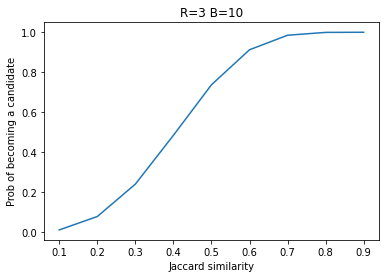

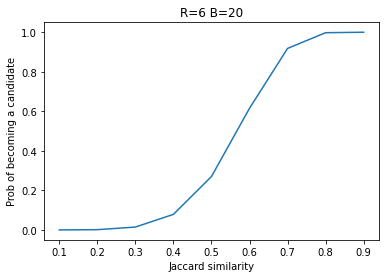

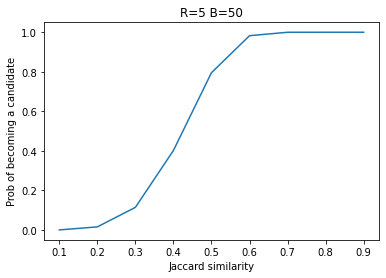

In [36]:
import matplotlib.pyplot as plt
vals = [(3,10), (6, 20), (5, 50)]

for r,b in vals:
  Y = []
  A = [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  for s in A:
    res = 1- (1-s**r)**b
    Y.append(res)
  plt.plot(A,Y)
  plt.ylabel("Prob of becoming a candidate")
  plt.xlabel("Jaccard similarity")
  plt.title("R={} B={}".format(r,b))
  plt.show()

**Exercise 3.4.2 : For each of the (r, b) pairs in Exercise 3.4.1, compute the threshold, that is, the value of s for which the value of $1−{(1−{s}^{r})}^{b}$ is exactly 1/2. How does this value compare with the estimate of ${(1/b)}^{1/r}$ that was suggested in Section 3.4.2?**


* for r=3, b=10,  $1−{(1−{s}^{r})}^{b}$ equals to 1/2 when s = 0.406, while ${(1/b)}^{(1/r)}$ equals 0.464
* for r = 6, b=20,  $1−{(1−{s}^{r})}^{b}$ equals to 1/2 when s=0.569, while ${(1/b)}^{(1/r)}$ equals 0.606
* for r = 5, b=50,  $1−{(1−{s}^{r})}^{b}$ equals to 1/2 when s = 0.424, while ${(1/b)}^{(1/r)}$ equals 0.457

Thus, the approximation is not very accurate (only to 1st order of magnitude, but will do the job for ball park approximation)